### all code depends on the assumption of third degree pol, and it is hardcoded accordingly... in the future it might be a good idea to generalize this code to work with any generic function...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

A_true = 0.
B_true = 0.6
C_true = 1
D_true = -0.5

def f_to_learn(x, a = A_true, b = B_true, c = C_true, d = D_true):
    # Define the coefficients of the third-degree polynomial equation
    return a + b*np.array(x) + c*np.array(x)**2 + d*np.array(x)**3

def gen_data(domain, N=1000):
    x = np.random.uniform(min(domain),max(domain),1000)
    mean = 0
    std_dev = 0.05 
    f_to_learn(x)+np.random.normal(mean, std_dev, x.shape)
    
    return x, f_to_learn(x)+np.random.normal(mean, std_dev, x.shape)

### plot the function we want to learn

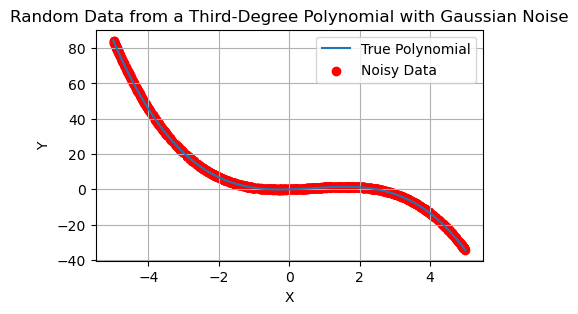

In [2]:
# Generate x values (input data)
x_true = np.linspace(-5, 5, 100)  # Adjust the range as needed

# Generate y values (output data) using the polynomial equation
y_true = f_to_learn(x_true)

# Generate data with noise from the polynomial equation
x_data, y_data = gen_data(x_true)

# Plot the original polynomial and the noisy data
plt.figure(figsize=(5, 3))
plt.plot(x_true, y_true, label="True Polynomial")
plt.scatter(x_data, y_data, c='r', marker='o', label="Noisy Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Random Data from a Third-Degree Polynomial with Gaussian Noise")
plt.grid(True)
plt.show()

In [3]:
def train_diff_prog_model(x_true, LR=0.0001, silent=False):

    x_data, y_data = gen_data(x_true)

    # Convert NumPy arrays to PyTorch tensors
    x_tensor = torch.tensor(x_data, dtype=torch.float32).view(-1, 1)
    y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)

    # Define a simple neural network model
    class PolynomialModel(nn.Module):
        def __init__(self):
            super(PolynomialModel, self).__init__()

            self.a = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))  # Parameter 'a'
            self.b = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))  # Parameter 'b'
            self.c = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))  # Parameter 'c'
            self.d = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))  # Parameter 'd'

        def forward(self, x):
            return self.a + x * self.b + x**2 * self.c + x**3 * self.d

    # Initialize the model
    model = PolynomialModel()
    
    if not silent:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print (name, param.data)

    # Define the loss function (mean squared error) and the optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)  # Using Adam optimizer

    # Training loop
    num_epochs = 50000

    a_list = []
    b_list = []
    c_list = []
    d_list = []
    loss_list = []
    for epoch in range(num_epochs):
        # Forward pass
        y_pred = model(x_tensor)

        # Compute the loss
        loss = criterion(y_pred, y_tensor)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        a_list.append(model.a.item())
        b_list.append(model.b.item())
        c_list.append(model.c.item())
        d_list.append(model.d.item())
        loss_list.append(loss.item())

        if (epoch + 1) % 10000 == 0 and not silent:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            
    return x_data, y_data, a_list, b_list, c_list, d_list, loss_list


def plot_param_evol(a_list, b_list, c_list, d_list, title=None):

    iters = range(len(a_list))

    c1 = 'r'
    c2 = 'g'
    c3 = 'cyan'
    c4 = 'b'

    plt.figure(figsize=(5, 3))
    plt.plot(iters,a_list, color = c1, label='a')
    plt.plot(iters,b_list, color = c2, label='b')
    plt.plot(iters,c_list, color = c3, label='c')
    plt.plot(iters,d_list, color = c4, label='d')

    plt.axhline(A_true, linestyle='--', color=c1)
    plt.axhline(B_true, linestyle='--', color=c2)
    plt.axhline(C_true, linestyle='--', color=c3)
    plt.axhline(D_true, linestyle='--', color=c4)

    plt.legend(ncol=1, frameon=False, bbox_to_anchor=(1.15, 1.05), loc='upper center')
    plt.gca().set_xlabel('epoch')
    plt.gca().set_ylabel('parameter value')
    if title:
        plt.title(title)
    
def plot_loss(loss_list):
    plt.figure(figsize=(5, 3))
    plt.plot(range(len(a_list)),loss_list, label='loss')
    plt.gca().set_xlabel('epoch')
    plt.gca().set_ylabel('loss value')
    
    
def plot_all(a_list, b_list, c_list, d_list, loss_list, title=None):

    iters = range(len(a_list))

    c1 = 'r'
    c2 = 'g'
    c3 = 'cyan'
    c4 = 'b'

    plt.figure(figsize=(5, 3))
    plt.plot(iters,a_list, color = c1, label='a')
    plt.plot(iters,b_list, color = c2, label='b')
    plt.plot(iters,c_list, color = c3, label='c')
    plt.plot(iters,d_list, color = c4, label='d')

    plt.axhline(A_true, linestyle='--', color=c1)
    plt.axhline(B_true, linestyle='--', color=c2)
    plt.axhline(C_true, linestyle='--', color=c3)
    plt.axhline(D_true, linestyle='--', color=c4)

    
    plt.gca().set_xlabel('epoch')
    plt.gca().set_ylabel('parameter value')
    if title:
        plt.title(title)
        
    # Manually add a legend that combines both variables
    lines1, labels1 = plt.gca().get_legend_handles_labels()
    
    # Create a second axis that shares the same x-axis
    ax2 = plt.gca().twinx()

    # Plot the second variable on the second axis
    ax2.plot(iters, loss_list, color='k', label='loss', lw=3)
    ax2.set_ylabel('loss')
    ax2.set_yscale('log')
    lines2, labels2 = ax2.get_legend_handles_labels()
    #plt.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.legend(lines1 + lines2, labels1 + labels2, ncol=5, frameon=False, bbox_to_anchor=(0.5, 1.25), loc='upper center')

### do the actual training

In [4]:
# Train the model and get the list of parameters and losses vs epoch
x_data, y_data, a_list, b_list, c_list, d_list, loss_list = train_diff_prog_model(x_true)

a tensor(1.)
b tensor(1.)
c tensor(1.)
d tensor(1.)
Epoch [10000/50000], Loss: 674.7477
Epoch [20000/50000], Loss: 1.3883
Epoch [30000/50000], Loss: 0.0627
Epoch [40000/50000], Loss: 0.0024
Epoch [50000/50000], Loss: 0.0024


### plot the learned function

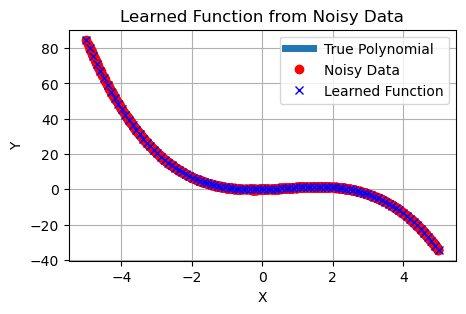

In [5]:
y_pred = f_to_learn(x_true, a_list[-1], b_list[-1], c_list[-1], d_list[-1])

plt.figure(figsize=(5, 3))
plt.plot(x_true, y_true, label="True Polynomial", lw=5)
plt.plot(x_data, y_data, 'ro', label='Noisy Data')
plt.plot(x_true, y_pred, 'xb-', lw=0, label='Learned Function')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Learned Function from Noisy Data")
plt.grid(True)
plt.show()

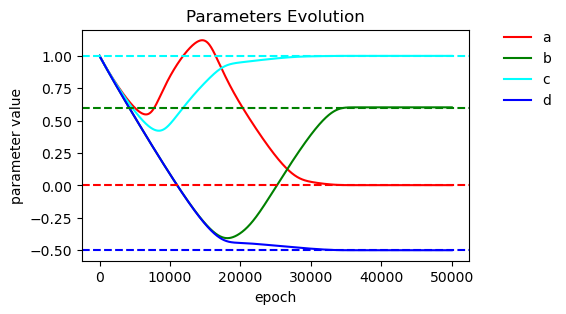

In [6]:
plot_param_evol(a_list, b_list, c_list, d_list, 'Parameters Evolution')

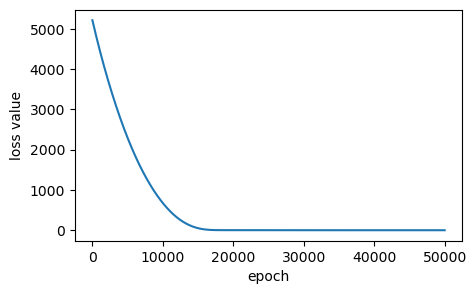

In [7]:
plot_loss(loss_list)

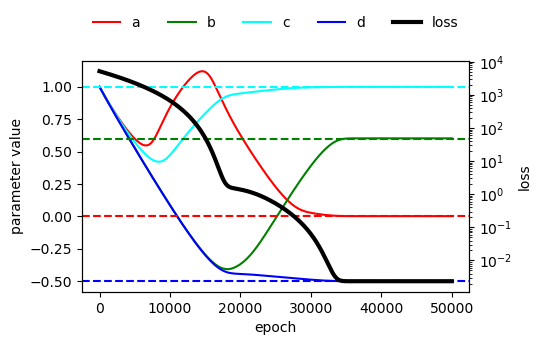

In [8]:
plot_all(a_list, b_list, c_list, d_list,loss_list)

### now let's study the role of the learning rate

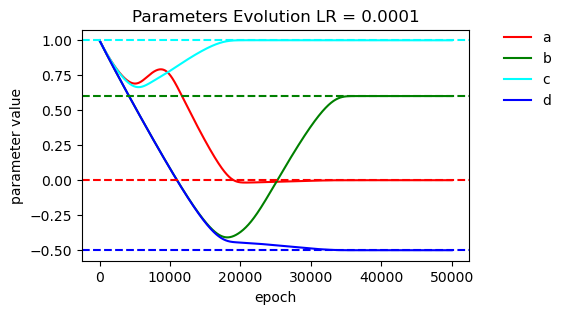

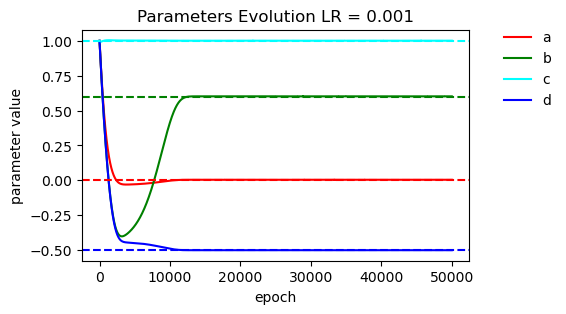

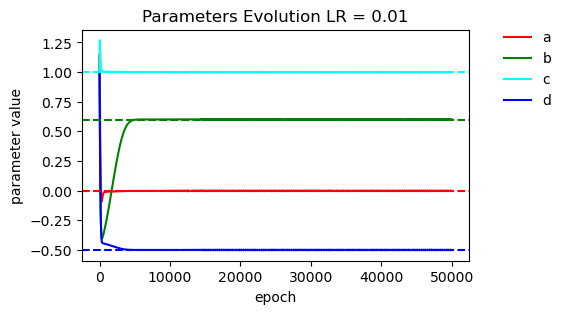

In [9]:
losses = []
LRs = [0.0001, 0.001, 0.01]

for LR in LRs:
    x_data, y_data, a_list, b_list, c_list, d_list, loss_list = train_diff_prog_model(x_true, LR, True)
    plot_param_evol(a_list, b_list, c_list, d_list, 'Parameters Evolution '+ 'LR = ' + str(LR))
    losses.append(loss_list)

### Now let's check the loss evolution for different learning rates

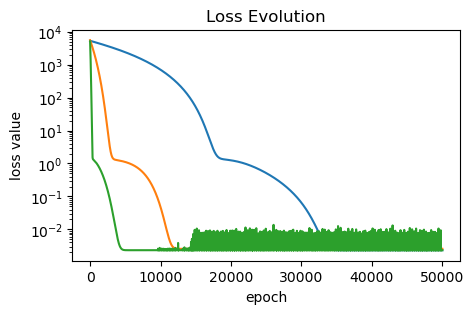

In [10]:
plt.figure(figsize=(5, 3))
for l in zip(losses,LRs):
    plt.plot(range(len(l[0])), l[0], label = 'LR '+ str(l[1]))
    
plt.gca().set_xlabel('epoch')
plt.gca().set_ylabel('loss value')
plt.gca().set_yscale('log')
_ = plt.title('Loss Evolution')

### same, now combining both the loss and the parameters in one plot

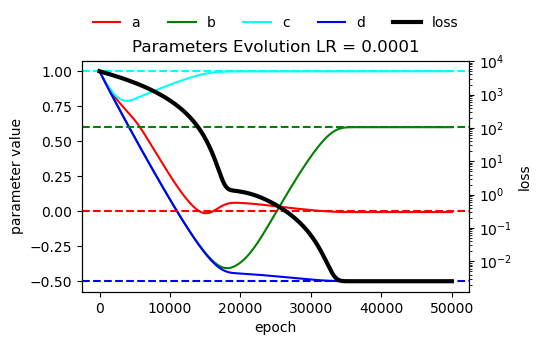

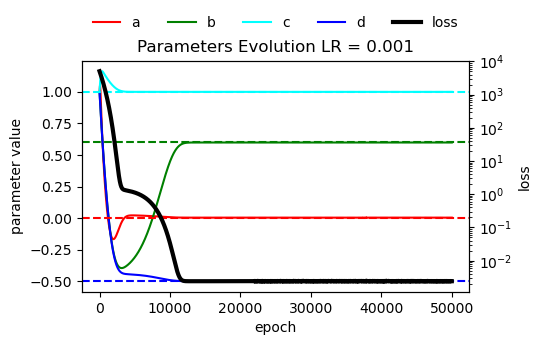

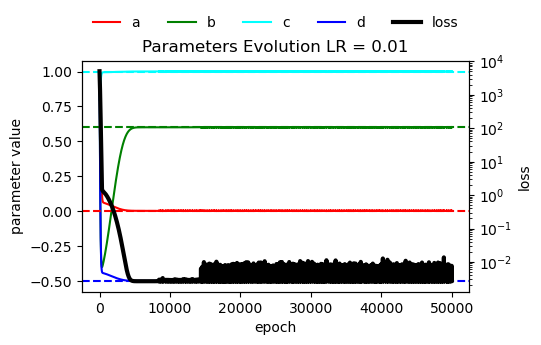

In [11]:
losses = []
LRs = [0.0001, 0.001, 0.01]

for LR in LRs:
    x_data, y_data, a_list, b_list, c_list, d_list, loss_list = train_diff_prog_model(x_true, LR, True)
    plot_all(a_list, b_list, c_list, d_list,loss_list,'Parameters Evolution '+ 'LR = ' + str(LR))